In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic_dd
import pandas as pd
from itertools import product
import os
import sys
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
sys.path.append("../data_extraction/")
from utils import flatten_logic, Serialization
from functools import reduce
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
tqdm.pandas()

In [2]:
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']
NUM_QUANTILES = 4
lemmatizer = WordNetLemmatizer()

In [3]:
def get_bins(data, num_bins):
    """Return the bin index that each data point in data falls into, given the space
    is subdivided to have num_bins equally sized bins.

    A bin number of i means that the corresponding value is between bin_edges[i-1], bin_edges[i]

    Returns both the bin index as a unique integer, as well as in terms of a 5d
    array corresponding to each dimension.
    """
    # Initialize uniformly-sized bins
    bin_edges = []
    for feature in FEATURE_COLUMNS:
        bin_edges.append(np.quantile(data[feature], np.linspace(0, 1, num_bins + 1)))
    bin_edges = np.array(bin_edges)
    bin_edges[:, 0] = 0
    bin_edges[:, -1] = 1

    data = data.to_numpy()
    
    stats, edges, unraveled_binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                            statistic="mean",
                                                            bins=bin_edges,
                                                            expand_binnumbers=True)

    # Return the bin IDs
    return unraveled_binnumber.transpose()

In [4]:
# ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_pipeline/dec_6_full_run/full_features/"
# files = sorted(os.listdir(ROOT_DIR))
# dfs = []
# for file in tqdm(files):
#     df = pd.read_csv(ROOT_DIR + file)
#     dfs.append(df)
# df = pd.concat(dfs)
# del dfs
# df = df.set_index("id")
# print("Getting marker")
# df['rel_marker'] = df['rel_marker'].progress_apply(lambda x: eval(x)[0])
# print("Rescaling Politeness")
# df['Politeness'] = (df["Politeness"] - df['Politeness'].min())/(df['Politeness'].max() - df['Politeness'].min())

# def get_bin_names(arr):
#     features = np.array(list("VADPF"))
#     added = np.char.add(features, arr.astype(str))
#     names = np.sum(added.astype(object), axis=1)
#     return names

# print("Extracting Bins")
# ubins = get_bins(df[FEATURE_COLUMNS], NUM_QUANTILES)
# print("Getting bin names")
# df['bin'] = get_bin_names(ubins)
# print("Describing bin")
# df['bin'].describe()

In [6]:
print("Getting mean data")
x = df.groupby("bin").mean()[FEATURE_COLUMNS]
print("Saving mean data")
Serialization.save_obj(x, f"semantic_situation_mean_values_{NUM_QUANTILES}_full_data")
print("Saving entire dataset")
Serialization.save_obj(df[['subreddit', 'rel_marker', 'bin', 'Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']], f"stance_pipeline_full_data_{NUM_QUANTILES}_quantiles_full_data")


Getting mean data
Saving mean data
Saving entire dataset


In [5]:
df = Serialization.load_obj(f"stance_pipeline_full_data_{NUM_QUANTILES}_quantiles_full_data")
x = df.groupby("bin").mean()[FEATURE_COLUMNS]
# df['rel_marker'] = df['rel_marker'].progress_apply(lambda x: marker_to_adjusted_lemma[x])

In [6]:
# Get all unique markers
# Takes about 1 min 12 s
all_markers = sorted(df['rel_marker'].unique())
all_markers = [marker for marker in all_markers if marker not in ["'d", "10x"]]
df = df[df['rel_marker'].isin(all_markers)]
# Combine the subreddit and marker and aggregate
df['sub_marker'] = df["subreddit"] + "_" + df['rel_marker']
agg = df.groupby(["bin", "sub_marker"]).count()

In [7]:
# Get all unique communities and bins
# Takes 12 seconds
comms = df['subreddit'].unique()
markers = df['rel_marker'].unique()
bins = df['bin'].unique()
com_markers = list(product(comms, markers))
com_markers = ["_".join(pair) for pair in com_markers]
len(com_markers)

102304

In [8]:
# Need probability
# Takes 30 seconds to run
# sem_sit_counts = df.groupby(["bin"]).count()['sub_marker']
sem_sit_counts_per_community = df.groupby(["subreddit", "bin"]).count()[['sub_marker', "Valence"]]
all_sub_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, comms], names=["bin", "subreddit"]), columns=sem_sit_counts_per_community.columns)
sem_sit_counts_per_community = sem_sit_counts_per_community.add(all_sub_counts, fill_value=0)
sem_sit_counts_per_community['percent'] = sem_sit_counts_per_community.groupby(level=0)['sub_marker'].transform(lambda x: (x / x.sum()))
# norm_sem_sit_counts = sem_sit_counts/sem_sit_counts.sum()
# print(norm_sem_sit_counts.describe())
com_to_need = {}
for sub in comms:
    need_vec = sem_sit_counts_per_community.loc[sub]['percent']
    com_to_need[sub] = need_vec.to_numpy()
need_df = pd.DataFrame(com_to_need).T
need_df.columns = sem_sit_counts_per_community.loc[sub].index
need_df.describe()

bin,V1A1D1P1F1,V1A1D1P1F2,V1A1D1P1F3,V1A1D1P1F4,V1A1D1P2F1,V1A1D1P2F2,V1A1D1P2F3,V1A1D1P2F4,V1A1D1P3F1,V1A1D1P3F2,...,V4A4D4P2F3,V4A4D4P2F4,V4A4D4P3F1,V4A4D4P3F2,V4A4D4P3F3,V4A4D4P3F4,V4A4D4P4F1,V4A4D4P4F2,V4A4D4P4F3,V4A4D4P4F4
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,...,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,0.002242,0.001492,0.001071,0.000823,0.002292,0.001789,0.001374,0.001056,0.002047,0.001745,...,0.001082,0.001279,0.001109,0.001494,0.001845,0.002198,0.003359,0.003206,0.003687,0.004154
std,0.000793,0.000523,0.000456,0.000621,0.000692,0.000452,0.000405,0.000707,0.000603,0.000389,...,0.000492,0.000641,0.000556,0.000786,0.001063,0.001346,0.002517,0.001872,0.002484,0.003216
min,0.000256,0.000480,0.000215,0.000064,0.000428,0.000652,0.000391,0.000201,0.000624,0.000715,...,0.000271,0.000199,0.000081,0.000231,0.000359,0.000231,0.000319,0.000393,0.000680,0.000864
25%,0.001727,0.001114,0.000678,0.000384,0.001901,0.001484,0.001109,0.000587,0.001703,0.001515,...,0.000730,0.000784,0.000652,0.000885,0.001072,0.001267,0.001901,0.001737,0.001892,0.002080
50%,0.002203,0.001507,0.001046,0.000712,0.002257,0.001824,0.001352,0.000923,0.002007,0.001697,...,0.000918,0.001241,0.000952,0.001174,0.001484,0.001792,0.002993,0.002674,0.002711,0.002887
75%,0.002706,0.001788,0.001381,0.001072,0.002725,0.002047,0.001656,0.001253,0.002287,0.002040,...,0.001363,0.001689,0.001509,0.002097,0.002545,0.002910,0.004382,0.004316,0.005333,0.005505
max,0.005237,0.003102,0.002742,0.003895,0.004494,0.003225,0.002556,0.005554,0.004890,0.002832,...,0.002731,0.003125,0.002527,0.003472,0.006084,0.007752,0.021749,0.009998,0.014249,0.021208


In [9]:
def get_nonzero_prop(df):
    print(np.round(np.count_nonzero(df)/df.size, 2))
    
# # Create a matrix of all possible semantic situations and community markers with 0 values
# full_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, com_markers], names=["bin", "sub_marker"]), columns=agg.columns)
# # Add to our attested matrix to fill in the blanks and get a full matrix
# total = agg.add(full_counts, fill_value=0)
# total = total.reset_index()
# # Create co-occurrence matrices
# print("Starting COOC Crosstab")
# cooc_matrix = pd.crosstab(total['bin'], total['sub_marker'], total['subreddit'], aggfunc="sum")
# print(f"Full Co-occurrence Matrix Size: {cooc_matrix.shape}")
# get_nonzero_prop(cooc_matrix)
# pav_matrix = pd.crosstab(df['subreddit'], df['rel_marker'])
# print(f"Pavalanathan Matrix Size: {pav_matrix.shape}")
# get_nonzero_prop(pav_matrix)

In [10]:
# Serialization.save_obj(pav_matrix, "pavalanathan_cooc_data_full_data_lemmatized")
# Serialization.save_obj(cooc_matrix, "our_cooc_data_full_data_lemmatized")

In [11]:
# markers = sorted(markers)
# lemmatized = []
# for token in tqdm(markers):
#     if token.endswith("ing"):
#         lemmatized.append(token)
#     else:
#         doc = lemmatizer.lemmatize(token, wordnet.VERB)
#         lemmatized.append(doc)
# marker_df = pd.DataFrame([markers, lemmatized], index=["og", "lem"]).T
# marker_to_lemma = dict(zip(markers, lemmatized))
# marker_to_adjusted_lemma = {}
# lemma_counts = Counter(lemmatized)
# for marker in markers:
#     if lemma_counts[marker_to_lemma[marker]] > 1:
#         marker_to_adjusted_lemma[marker] = marker_to_lemma[marker]
#     else:
#         marker_to_adjusted_lemma[marker] = marker

alarmingly (25) -> adj
amazing (38) -> adj
amusing (42) -> adj
annoying (49) -> adj
appalled (56) -> adj
appallingly (57) -> adj
astonishing (92) -> adj
astounding (94) -> adj
baffling (105) -> adj
calculating (128) -> adj
'd, 10x gone

assertions (82) -> noun WHY HERE
assumptions (87) -> noun WHY HERE
conclusions (158) -> noun WHY HERE
enchantment (323) -> noun WHY HERE
definately (204) -> misspelling
definetly (205) -> misspelling
dissapointed (278) -> misspelling
evidence/evidenced (348) -> noun?

What do we do about cases like "ed", where loved vs love, but also "he is loved" (positive adjective). Alternatively, desensitize (though this is the lone word like this, so it's not a problem). Despised, determined, distracted (though by itself), distressed, dumbfounded (by itself), ("embarrassed"), enchanted, enraged (by itself), established (337), estimated 341
Not a clear way to assess the situations above while also accounting for "s", except for saying all "ed" are adjectives. For lone words, it doesn't matter.
Keep disgusted, disgusting, disgustingly separate.

PLACER = 280
marker_df.iloc[PLACER:PLACER + 20].T

In [12]:
pav_matrix = Serialization.load_obj("pavalanathan_cooc_data_full_data")
cooc_matrix = Serialization.load_obj("our_cooc_data_full_data")

In [13]:
# # Extract co-occurrence matrix per subreddit to get words that are sufficiently infrequent
# all_subs = []
# for i in range(len(comms)):
#     sub = cooc_matrix.iloc[:, i*len(markers):(i+1)*len(markers)]
#     sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
#     all_subs.append(sub)

# whole_counts = reduce(lambda a, b: a.add(b, fill_value=0), all_subs)
# whole_agg = whole_counts.sum()
# markers_to_keep = whole_agg.index#set(whole_agg[whole_agg <= 100000].index)
# cooc_matrix = cooc_matrix[[col for col in cooc_matrix.columns if col[col.find("_") + 1:] in markers_to_keep]]
# pav_matrix = pav_matrix[[col for col in pav_matrix.columns if col in markers_to_keep]]


# cooc_sum = cooc_matrix.sum()
# adjusted_cooc_matrix = cooc_matrix[cooc_sum[cooc_sum != 0].index]

In [14]:
len(com_markers)

102304

In [15]:
# all_ppmis = []
# for i in tqdm(range(len(comms))):
#     sub = cooc_matrix_np[:, i*len(markers):(i+1)*len(markers)]
#     # sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
#     curr_ppmi = pmi(sub)
#     all_ppmis.append(curr_ppmi)

In [16]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
        df = np.nan_to_num(df)
    return df

In [17]:
def create_derived_representation(matrix, include_ppmi=True):
    matrix_np = matrix.to_numpy()
    print(matrix_np.shape)
    if include_ppmi:
        svd_input = pmi(matrix_np)
    else:
        svd_input = matrix_np
    get_nonzero_prop(svd_input)
    P, D, Q = np.linalg.svd(svd_input, full_matrices=False)
    output = {
        "svd_input": svd_input,
        "sem_rep": P,
        "singular_values": D,
        "marker_rep": Q,
        'sem_loadings': np.multiply(P, D),
        'marker_loadings': np.multiply(D.reshape(-1, 1), Q)
    }
    
    return output


def scree_plot(sing_val_matrix, to_show=True):
    eigenvalues = sing_val_matrix**2

    var_explained = sing_val_matrix**2/np.sum(sing_val_matrix**2)
    total_var_explained = np.concatenate(([0], np.cumsum(var_explained)))
    var_explained = np.round(var_explained, 3)
    if to_show:
        plt.clf()
        plt.plot(np.arange(len(eigenvalues[:10])) + 1, eigenvalues[:10])
        plt.xlabel("Component Number")
        plt.ylabel("Eigenvalue (x10^6)")
        plt.title("Eigenvalues of Each Component")
        plt.show()
        print(var_explained[:10])
        print(total_var_explained[:10])
        plt.clf()
        plt.plot(np.arange(len(var_explained[:10])) + 1, var_explained[:10])
        plt.xlabel("Component Number")
        plt.ylabel("Variance Explained")
        plt.title("Proportion of Variance Explained by Each Component")
        plt.show()
        plt.clf()
        plt.plot(np.arange(-1, len(total_var_explained[:10])) + 1, total_var_explained[:11])
        plt.ylim(0, np.max(total_var_explained[:11]) + 0.02)
        plt.xlabel("Component Number")
        plt.ylabel("Cumulative Variance Explained")
        plt.title("Cumulative Variance Explained Across Components")
        plt.show()
    return eigenvalues, var_explained, total_var_explained

In [55]:
matrices = [cooc_matrix, cooc_matrix, pav_matrix, pav_matrix, pav_matrix, pav_matrix]
labels = ["our_raw_90_var", "our_ppmi_90_var", "pav_raw_8_dim", "pav_ppmi_8_dim", "pav_raw_90_var", "pav_ppmi_90_var"]
delegates = [lambda x: create_derived_representation(x, include_ppmi=False), lambda x: create_derived_representation(x, include_ppmi=True), lambda x: create_derived_representation(x, include_ppmi=False), lambda x: create_derived_representation(x, include_ppmi=True), lambda x: create_derived_representation(x, include_ppmi=False), lambda x: create_derived_representation(x, include_ppmi=True)]

In [216]:
# cooc_matrix_np = cooc_matrix.to_numpy()
# P, D, Q = np.linalg.svd(cooc_matrix_np, full_matrices=False)
# (D**2/np.sum(D**2))
# (np.multiply(P, D)**2).sum(axis=0)
# LOADINGS = np.multiply(D.reshape(-1, 1), Q)

https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another 
https://stats.stackexchange.com/questions/92499/how-to-interpret-pca-loadings/92512#92512

In [56]:
all_data = {}
for matrix, label, delegate in zip(matrices, labels, delegates):
    curr_output = delegate(matrix)
    all_data[label] = curr_output

(1024, 102304)
0.09
(1024, 102304)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


0.07
(92, 1112)
0.88
(92, 1112)
0.33
(92, 1112)
0.88
(92, 1112)
0.33


In [57]:
def num_dim_to_keep(total_var_explained, label):
    if label.endswith("8_dim"):
        return 8
    else:
        return np.argmax(total_var_explained>0.9)


In [58]:
for label in labels:
    eigenvalues, var_explained, total_var_explained = scree_plot(all_data[label]['singular_values'], to_show=False)
    all_data[label]['eigenvalues'] = eigenvalues
    all_data[label]['var_explained'] = var_explained
    all_data[label]['total_var_explained'] = total_var_explained
    all_data[label]['num_dim_to_keep'] = num_dim_to_keep(total_var_explained, label)
    all_data[label]['new_sem_rep'] = all_data[label]['sem_rep'][:, :all_data[label]['num_dim_to_keep']]
    all_data[label]['new_marker_rep'] = all_data[label]['marker_rep'].T[:, :all_data[label]['num_dim_to_keep']].reshape(-1, all_data[label]['num_dim_to_keep'])
    all_data[label]['new_sem_loadings'] = all_data[label]['sem_loadings'][:, :all_data[label]['num_dim_to_keep']]
    all_data[label]['new_marker_loadings'] = all_data[label]['marker_loadings'].T[:, :all_data[label]['num_dim_to_keep']].reshape(-1, all_data[label]['num_dim_to_keep'])


In [22]:
all_data[labels[0]]['new_marker_loadings'].shape

(102304, 9)

In [134]:
# var_explained_df = pd.DataFrame([np.round(eigenvalues), np.round(var_explained, 3), np.round(total_var_explained[1:], 3)], index=["Eigenvalues", "Variance Explained", "Total Variance Explained"])
# var_explained_df[var_explained_df.columns[:10]].to_csv("variance_explained_top_10.csv")
# for quantile in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
#     print(np.argmax(total_var_explained>quantile))

In [23]:
x = df.groupby("bin")[FEATURE_COLUMNS].mean()
x = x.loc[cooc_matrix.index]

In [299]:
LATENT_DIM_NUM = 0
print(np.round(spearmanr(new_P[:, LATENT_DIM_NUM], x['Valence'])[0], 2))
print(np.round(spearmanr(new_P[:, LATENT_DIM_NUM], x['Arousal'])[0], 2))
print(np.round(spearmanr(new_P[:, LATENT_DIM_NUM], x['Dominance'])[0], 2))
print(np.round(spearmanr(new_P[:, LATENT_DIM_NUM], x['Politeness'])[0], 2))
print(np.round(spearmanr(new_P[:, LATENT_DIM_NUM], x['Formality'])[0], 2))


0.06
0.02
-0.09
0.13
-0.05


In [25]:
def get_abs_diff(pair):
    bin_1, bin_2 = pair
    return np.abs(x.loc[bin_1].to_numpy() - x.loc[bin_2].to_numpy())

def get_diff(pair):
    bin_1, bin_2 = pair
    return x.loc[bin_1].to_numpy() - x.loc[bin_2].to_numpy()

In [171]:
rows = []
indices = []
with Pool(6) as p:
    for i in tqdm(range(len(x.index)-1)):
        bin_1 = x.index.tolist()[i]
        input_vals = list(product([bin_1], x.iloc[i+1:].index))
        r = list(p.imap(get_abs_diff, input_vals))
        rows.extend(r)
        indices.extend(input_vals)

100%|██████████| 1023/1023 [00:33<00:00, 30.58it/s] 


In [172]:
sem_sit_sims_derived = pd.DataFrame(cosine_similarity(new_P), columns=cooc_matrix.index, index=cooc_matrix.index)
pairwise_distances = pd.DataFrame(np.array(rows), columns=FEATURE_COLUMNS, index=pd.MultiIndex.from_tuples(indices))
pairwise_distances['Derived_Dist'] = pairwise_distances.progress_apply(lambda y: sem_sit_sims_derived.loc[y.name[0]][y.name[1]], axis=1)
# Serialization.save_obj(pairwise_distances, f"semantic_situation_regression_input_{NUM_QUANTILES}_full_data_3_dim")

# pairwise_distances = pd.DataFrame(np.array(rows), columns=FEATURE_COLUMNS, index=pd.MultiIndex.from_tuples(indices))
# pairwise_distances['Derived_Dist'] = pairwise_distances.progress_apply(lambda y: sem_sit_sims_derived.loc[y.name[0]][y.name[1]], axis=1)
# Serialization.save_obj(pairwise_distances, f"semantic_situation_regression_input_{NUM_QUANTILES}_full_data_3_dim_true_diff")

100%|██████████| 523776/523776 [00:55<00:00, 9495.75it/s] 


In [183]:
spearmanr(pairwise_distances['Politeness'], 1-pairwise_distances['Derived_Dist'])

SpearmanrResult(correlation=0.24451093978803165, pvalue=0.0)

In [162]:
def calculate_pairwise_sim(data):
    pairwise_sim = 1 - pd.DataFrame(cosine_similarity(data, data), index=x.index, columns=x.index)
    pairwise_sim = pairwise_sim.where(np.triu(np.ones(pairwise_sim.shape), k=1).astype(np.bool))
    pairwise_sim = pairwise_sim.stack().rename("Original_Dist")
    pairwise_sim.index = pairwise_sim.index.rename(["Sit 1", "Sit 2"])
    return pd.DataFrame(pairwise_sim)


In [163]:
full_space_sims = calculate_pairwise_sim(x)
full_space_sims['Derived_Dist'] = 1- full_space_sims.progress_apply(lambda y: sem_sit_sims_derived.loc[y.name[0]][y.name[1]], axis=1)

100%|██████████| 523776/523776 [00:54<00:00, 9638.62it/s]


In [196]:
feat_to_dist = {}
for feature in FEATURE_COLUMNS:
    x_copy = x[[col for col in x.columns if col != feature]]
    curr_space_sims = calculate_pairwise_sim(x_copy)
    curr_space_sims['Derived_Dist'] = full_space_sims['Derived_Dist']
    feat_to_dist[feature] = curr_space_sims

In [188]:
# pairwise_distances = Serialization.load_obj(f"semantic_situation_regression_input_{NUM_QUANTILES}_full_data_3_dim")
# pairwise_distances

In [170]:
spearmanr(example_df['Original_Dist_Full'], example_df['Original_Dist_Formality'])

SpearmanrResult(correlation=0.2615259377070754, pvalue=0.0)

In [167]:
example_df = pd.concat((full_space_sims, feat_to_dist['Formality']), axis=1)
example_df.columns = ["Original_Dist_Full", "D", "Original_Dist_Formality", "Derived_Dist"]
example_df[["Original_Dist_Full", "Original_Dist_Formality", "Derived_Dist"]]

Original_Dist_Full  Original_Dist_Formality  \
Sit 1      Sit 2                                                     
V1A1D1P1F1 V1A1D1P1F2            0.014607                 0.000030   
           V1A1D1P1F3            0.043433                 0.000061   
           V1A1D1P1F4            0.099338                 0.000127   
           V1A1D1P2F1            0.004785                 0.005215   
           V1A1D1P2F2            0.016597                 0.005280   
...                                   ...                      ...   
V4A4D4P4F1 V4A4D4P4F3            0.016019                 0.000580   
           V4A4D4P4F4            0.040745                 0.000996   
V4A4D4P4F2 V4A4D4P4F3            0.003191                 0.000069   
           V4A4D4P4F4            0.017508                 0.000253   
V4A4D4P4F3 V4A4D4P4F4            0.005783                 0.000062   

                       Derived_Dist  
Sit 1      Sit 2                     
V1A1D1P1F1 V1A1D1P1F2      0.055333  
           V1A1D1P1F3      0.263529  
           V1A1D1P1F4      0.829956  
           V1A1D1P2F1      0.011445  
           V1A1D1P2F2      0.070709  
...                             ...  
V4A4D4P4F1 V4A4D4P4F3      0.193313  
           V4A4D4P4F4      0.472229  
V4A4D4P4F2 V4A4D4P4F3      0.042822  
           V4A4D4P4F4      0.220246  
V4A4D4P4F3 V4A4D4P4F4      0.073157  

[523776 rows x 3 columns]

In [165]:
full_space_sims

Original_Dist  Derived_Dist
Sit 1      Sit 2                                  
V1A1D1P1F1 V1A1D1P1F2       0.014607      0.055333
           V1A1D1P1F3       0.043433      0.263529
           V1A1D1P1F4       0.099338      0.829956
           V1A1D1P2F1       0.004785      0.011445
           V1A1D1P2F2       0.016597      0.070709
...                              ...           ...
V4A4D4P4F1 V4A4D4P4F3       0.016019      0.193313
           V4A4D4P4F4       0.040745      0.472229
V4A4D4P4F2 V4A4D4P4F3       0.003191      0.042822
           V4A4D4P4F4       0.017508      0.220246
V4A4D4P4F3 V4A4D4P4F4       0.005783      0.073157

[523776 rows x 2 columns]

In [197]:
total_corr, total_p = spearmanr(full_space_sims['Original_Dist'], full_space_sims['Derived_Dist'])
print(total_corr)
for feature in FEATURE_COLUMNS:
    print(feature)
    curr_corr, curr_p = spearmanr(feat_to_dist[feature]['Original_Dist'], feat_to_dist[feature]['Derived_Dist'])
    print(np.round(curr_corr, 2), curr_p)
    print(f"Reduction in correlation for {feature}: {np.round(total_corr-curr_corr, 2)}")

0.5133156105474452
Valence
0.46 0.0
Reduction in correlation for Valence: 0.05
Arousal
0.49 0.0
Reduction in correlation for Arousal: 0.02
Dominance
0.47 0.0
Reduction in correlation for Dominance: 0.04
Politeness
0.51 0.0
Reduction in correlation for Politeness: 0.0
Formality
0.26 0.0
Reduction in correlation for Formality: 0.25


In [37]:
pairwise_distances['Derived_Dist'].describe()

count    523776.000000
mean          0.002220
std           0.029164
min          -0.379060
25%          -0.000466
50%           0.000005
75%           0.000490
max           0.708600
Name: Derived_Dist, dtype: float64

In [129]:
Serialization.load_obj("semantic_situation_regression_input_4_full_data")

Valence   Arousal  Dominance  Politeness  Formality  \
V1A1D1P1F1 V1A1D1P1F2  0.002282  0.005976   0.002008    0.002581   0.129889   
           V1A1D1P1F3  0.003939  0.009295   0.005749    0.003142   0.237282   
           V1A1D1P1F4  0.005155  0.014864   0.004347    0.003303   0.397906   
           V1A1D1P2F1  0.006474  0.007593   0.003411    0.073283   0.008467   
           V1A1D1P2F2  0.003956  0.009322   0.000273    0.073563   0.131466   
...                         ...       ...        ...         ...        ...   
V4A4D4P4F1 V4A4D4P4F3  0.051638  0.000492   0.004079    0.016355   0.232954   
           V4A4D4P4F4  0.062950  0.001075   0.012370    0.018931   0.390494   
V4A4D4P4F2 V4A4D4P4F3  0.017128  0.000727   0.001849    0.004161   0.107097   
           V4A4D4P4F4  0.028440  0.001310   0.010140    0.006737   0.264637   
V4A4D4P4F3 V4A4D4P4F4  0.011312  0.000583   0.008291    0.002576   0.157540   

                       Derived_Dist  
V1A1D1P1F1 V1A1D1P1F2      0.856745  
           V1A1D1P1F3      0.600191  
           V1A1D1P1F4      0.158861  
           V1A1D1P2F1      0.987135  
           V1A1D1P2F2      0.856616  
...                             ...  
V4A4D4P4F1 V4A4D4P4F3      0.801036  
           V4A4D4P4F4      0.681500  
V4A4D4P4F2 V4A4D4P4F3      0.976313  
           V4A4D4P4F4      0.903936  
V4A4D4P4F3 V4A4D4P4F4      0.970146  

[523776 rows x 6 columns]

In [224]:
# Maps each feature to its quantile number in the semantic situation name (e.g. V1A2D1P2F1)
feature_to_index = {
    "Valence": 1,
    "Arousal": 3,
    "Dominance": 5,
    "Politeness": 7,
    "Formality": 9
}

quantile_to_plot_markers = {
    2: ["ro", "gs"],
    3: ["ro", "bx", "gs"],
    4: ["ro", "bo", "ys", "gs"]
}

quantile_to_legend_labels = {
    2: ["Low", "High"],
    3: ["Low", "Mid", "High"],
    4: ["Low", "Midlow", "Midhigh", "High"]
}

def mds_visualization_2d(lowdim, labels, feature, delegate, plot_markers, delegate_labels, legend_labels, derived_label, to_annotate):
    # Rewrite into wrapper function that computes mds just once and can be used for an arbitrary number of features
    plt.rcParams.update({"font.size": 20})
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(delegate_labels)):
        vals = np.array([idx for idx, label in enumerate(labels) if delegate(label, delegate_labels[i], feature)]).astype(int)
        plt.plot(lowdim[vals, 0], lowdim[vals, 1], plot_markers[i], markersize=12, label=f"{legend_labels[i]} {feature}")
    plt.legend()
    if to_annotate:
        for i in range(len(lowdim)):
            plt.text(lowdim[i,0]*1.05, lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of {derived_label} Semantic Situation Space ({feature})")

def mds_visualization_3d(lowdim, labels, feature, delegate, plot_markers, delegate_labels, legend_labels, derived_label, to_annotate):
    # Rewrite into wrapper function that computes mds just once and can be used for an arbitrary number of features
    ax = plt.figure(figsize=(20, 10)).add_subplot(projection='3d')
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 1.5, 1.5, 1]))
    # ax.set_box_aspect(aspect = (1,1,2))
    for i in range(len(delegate_labels)):
        vals = np.array([idx for idx, label in enumerate(labels) if delegate(label, delegate_labels[i], feature)]).astype(int)
        ax.plot(lowdim[vals, 0], lowdim[vals, 1], lowdim[vals, 2], plot_markers[i], markersize=8, label=f"{legend_labels[i]} {feature}")
    ax.legend(loc='upper right')
    if to_annotate:
        for i in range(len(lowdim)):
            ax.text(lowdim[i,0]*1.05, lowdim[i,1]*1.01, lowdim[i,2]*1.01, labels[i],fontsize=17)

    ax.set_xlabel('Dimension 1')    
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.view_init(0, -75)
    plt.title(f"MDS Plot of {derived_label} Semantic Situation Space ({feature})")

def mds_wrapper(data, labels, features, delegate, num_quantiles=2, num_components=2, is_derived=False, to_annotate=False):
    embedding = MDS(n_components=num_components, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)

    plot_markers = quantile_to_plot_markers[num_quantiles]
    derived_label = "Derived" if is_derived else "Original"
    delegate_labels = [str(i+1) for i in range(num_quantiles)]
    legend_labels = quantile_to_legend_labels[num_quantiles]

    if num_components == 2:
        for feature in features:
            mds_visualization_2d(F_lowdim, labels, feature, delegate, plot_markers, delegate_labels, legend_labels, derived_label, to_annotate)
    else:
        for feature in features:
            mds_visualization_3d(F_lowdim, labels, feature, delegate, plot_markers, delegate_labels, legend_labels, derived_label, to_annotate)


In [301]:
original_dist_matrix = cosine_similarity(our_cooc)
derived_dist_matrix = cosine_similarity(new_P)
# original_dist_matrix = cdist(cooc_matrix_np, cooc_matrix_np)
# derived_dist_matrix = cdist(new_P, new_P)

In [68]:
# mds_wrapper(original_dist_matrix, cooc_matrix.index, FEATURE_COLUMNS, lambda x, y, z: x[feature_to_index[z]] == y, num_quantiles=NUM_QUANTILES, num_components=2, is_derived=False)
# mds_wrapper(derived_dist_matrix, cooc_matrix.index, FEATURE_COLUMNS, lambda x, y, z: x[feature_to_index[z]] == y, num_quantiles=NUM_QUANTILES, num_components=2, is_derived=False)


In [24]:
com_to_stance_usage = {"our_raw_90_var": {}, "our_ppmi_90_var": {}}
comms = sorted(comms)
for i in range(len(comms)):
    sub = all_data['our_raw_90_var']['new_marker_rep'][i*len(markers):(i+1)*len(markers), :]
    com_to_stance_usage['our_raw_90_var'][comms[i]] = sub
    sub = all_data['our_ppmi_90_var']['new_marker_rep'][i*len(markers):(i+1)*len(markers), :]
    com_to_stance_usage['our_ppmi_90_var'][comms[i]] = sub
    # sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
    

In [21]:
pairs = []
need_sims = []
stance_sims = []
adjusted_stance_sims = []
com_to_markers = {}
for com_1 in tqdm(comms):
    for com_2 in comms:
        if com_1 != com_2:
            if sorted((com_1, com_2)) in pairs:
                continue
            pairs.append(sorted((com_1, com_2)))
            # need_sims.append(cosine_similarity(com_to_need[com_1].reshape(1, -1), com_to_need[com_2].reshape(1, -1))[0][0])
            need_sims.append(np.abs(com_to_need[com_1].reshape(1, -1) - com_to_need[com_2].reshape(1, -1)).sum())
            stance_sims.append(np.mean(cosine_similarity(com_to_stance_usage[com_1], com_to_stance_usage[com_2]).diagonal()))

            if com_1 not in com_to_markers:
                shdf = cooc_matrix[[col for col in cooc_matrix.columns if col[:col.rfind("_")] == com_1]]
                markers_in_shdf = cosine_similarity(shdf.to_numpy().T, shdf.to_numpy().T).diagonal().nonzero()
                com_1_markers = set(markers_in_shdf[0])
                com_to_markers[com_1] = com_1_markers
            if com_2 not in com_to_markers:
                d3df = cooc_matrix[[col for col in cooc_matrix.columns if col[:col.rfind("_")] == com_2]]
                markers_in_d3df = cosine_similarity(d3df.to_numpy().T, d3df.to_numpy().T).diagonal().nonzero()
                com_2_markers = set(markers_in_d3df[0])
                com_to_markers[com_2] = com_2_markers

            common_markers = list(com_to_markers[com_1].intersection(com_to_markers[com_2]))
            adjusted_stance_sims.append(np.mean(cosine_similarity(com_to_stance_usage[com_1][common_markers, :], com_to_stance_usage[com_2][common_markers, :]).diagonal()))

100%|██████████| 92/92 [00:14<00:00,  6.13it/s]


In [22]:
np.polyfit(need_sims, stance_sims, 1)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([0.23274467, 0.23274467])

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


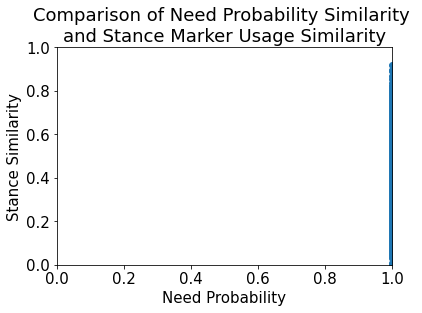

In [23]:
plt.clf()
plt.rcParams.update({"font.size": 15})
plt.scatter(need_sims, stance_sims)
plt.title("Comparison of Need Probability Similarity \nand Stance Marker Usage Similarity")
plt.xlabel("Need Probability")
plt.ylabel("Stance Similarity")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.unique(need_sims), np.poly1d(np.polyfit(need_sims, stance_sims, 1))(np.unique(need_sims)), color="red")

In [66]:
spearmanr(need_sims, stance_sims)

SpearmanrResult(correlation=0.5944142249064551, pvalue=0.0)

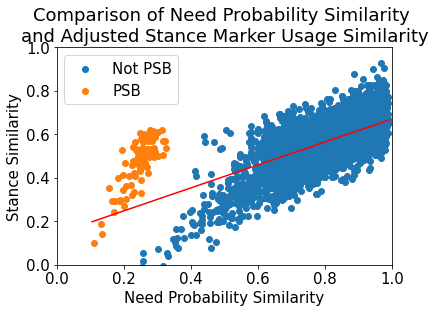

In [82]:
plt.title("Comparison of Need Probability Similarity \nand Adjusted Stance Marker Usage Similarity")
plt.scatter(new_need_sims, new_stance_sims, label="Not PSB")
plt.scatter(psb_need_sims, psb_stance_sims, label="PSB")
plt.xlabel("Need Probability Similarity")
plt.ylabel("Stance Similarity")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.plot(np.unique(need_sims), np.poly1d(np.polyfit(need_sims, adjusted_stance_sims, 1))(np.unique(need_sims)), color="red")

In [72]:
spearmanr(need_sims, adjusted_stance_sims)

SpearmanrResult(correlation=0.6768160578274767, pvalue=0.0)

In [75]:
new_pairs = []
new_need_sims = []
new_stance_sims = []

psb_pairs = []
psb_need_sims = []
psb_stance_sims = []

# np.array(pairs)[[np.argsort(need_sims)[:200]]]
for pair, need_sim, stance_sim in zip(pairs, need_sims, adjusted_stance_sims):
    if "photoshopbattles" not in pair:
        new_pairs.append(pair)
        new_need_sims.append(need_sim)
        new_stance_sims.append(stance_sim)
    else:
        psb_pairs.append(pair)
        psb_need_sims.append(need_sim)
        psb_stance_sims.append(stance_sim)

In [76]:
np.array(new_pairs)[[np.argsort(new_need_sims)[:92]]]

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([['askhistorians', 'percyjacksonrp'],
       ['askhistorians', 'steamgameswap'],
       ['amiugly', 'askhistorians'],
       ['askhistorians', 'teenagers'],
       ['askhistorians', 'globaloffensivetrade'],
       ['askhistorians', 'cardinals'],
       ['askhistorians', 'csgobetting'],
       ['askhistorians', 'femalefashionadvice'],
       ['femalefashionadvice', 'worldnews'],
       ['steamgameswap', 'worldnews'],
       ['makeupaddiction', 'worldnews'],
       ['askhistorians', 'makeupaddiction'],
       ['askhistorians', 'nrl'],
       ['askhistorians', 'frozen'],
       ['askhistorians', 'tifu'],
       ['askhistorians', 'hardwareswap'],
       ['askhistorians', 'music'],
       ['askhistorians', 'battlestations'],
       ['amiugly', 'worldnews'],
       ['askhistorians', 'jokes'],
       ['science', 'steamgameswap'],
       ['news', 'steamgameswap'],
       ['makeupaddiction', 'whowouldwin'],
       ['femalefashionadvice', 'whowouldwin'],
       ['percyjacksonrp', 'worldnew

In [100]:
np.array(new_stance_sims)[[np.argsort(new_need_sims)[:3]]]

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([-0.00973962,  0.01559757,  0.05471625])

In [280]:
spearmanr(stance_sims, adjusted_stance_sims)

SpearmanrResult(correlation=0.7374692447994537, pvalue=0.0)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
crossposting_df = pd.read_csv("../data_extraction/crossposting_full_community_data.csv")

In [233]:
all_data[labels[1]]['new_marker_rep'].shape

(102304, 802)

In [37]:
all_data['pav_ppmi_90_var']['new_sem_rep']

array([[-0.14222604, -0.05750234, -0.10543592, ...,  0.20782213,
         0.0050487 ,  0.01493497],
       [-0.04915944, -0.08312645,  0.01386803, ...,  0.07548566,
         0.068597  , -0.18663095],
       [-0.38519473,  0.44957705, -0.05536099, ..., -0.01296135,
         0.01828089,  0.08471742],
       ...,
       [-0.04530986, -0.06436785, -0.1662359 , ..., -0.08165667,
         0.16375873,  0.14855281],
       [-0.17024394, -0.03315002,  0.06574403, ...,  0.00716923,
        -0.0345707 , -0.0321998 ],
       [-0.03629156, -0.05404304, -0.09083954, ...,  0.09767944,
         0.08046199, -0.05244776]])

In [39]:
all_data['pav_ppmi_90_var']['new_sem_loadings']

array([[ -8.37164261,  -1.86663739,  -2.82953399, ...,   1.61893789,
          0.03881918,   0.11465673],
       [ -2.89359969,  -2.69844572,   0.37216972, ...,   0.58803454,
          0.52743836,  -1.43277826],
       [-22.67315194,  14.59414286,  -1.48569669, ...,  -0.10096912,
          0.14056072,   0.65038127],
       ...,
       [ -2.66700765,  -2.08950539,  -4.46119453, ...,  -0.63610682,
          1.2591314 ,   1.14044986],
       [-10.02081946,  -1.07611406,   1.76434164, ...,   0.05584841,
         -0.26581209,  -0.24719999],
       [ -2.13617656,  -1.75434198,  -2.43781799, ...,   0.76092445,
          0.61866763,  -0.40264492]])

In [251]:
pav_comms = pav_matrix.index.tolist()
for label in tqdm(labels):
    # pav_full_vals = []
    # pav_partial_vals = []
    # our_full_vals = []
    # our_partial_vals = []
    full_vals = []
    partial_vals = []
    for i, row in crossposting_df.iterrows():
        com_1, com_2 = row['com_1'], row['com_2']
        if label.startswith("pav"):
            # Pav data
            ci1, ci2 = pav_comms.index(com_1), pav_comms.index(com_2)
            ci1_rep = all_data[label]['new_sem_rep'][ci1].reshape(1, -1)
            ci2_rep = all_data[label]['new_sem_rep'][ci2].reshape(1, -1)
            pav_full = cosine_similarity(ci1_rep, ci2_rep)[0][0]
            full_vals.append(pav_full)

            pav_partial = np.abs(ci1_rep - ci2_rep)[0]
            partial_vals.append(pav_partial)
        else:
            # Our Data
            full_vals.append(np.mean(cosine_similarity(com_to_stance_usage[label][com_1], com_to_stance_usage[label][com_2]).diagonal()))
            partial_vals.append(np.abs(com_to_stance_usage[label][com_1] - com_to_stance_usage[label][com_2]).sum(axis=0))
    all_data[label]['full_crosspost'] = full_vals
    all_data[label]['partial_crosspost'] = partial_vals




100%|██████████| 6/6 [00:57<00:00,  9.60s/it]


In [283]:
crossposting_df['pav_full'] = pav_full_vals
crossposting_df['pav_partial'] = pav_partial_vals
crossposting_df['our_full'] = our_full_vals
crossposting_df['our_partial'] = our_partial_vals

In [252]:
NUM_CV = 5
L1_RATIO=0.5

df_data = []
for label in labels:
    lr = LogisticRegression(random_state=42, penalty='l2', solver="lbfgs")#, l1_ratio=L1_RATIO)
    full_scores = cross_val_score(lr, np.array(all_data[label]['full_crosspost']).reshape(-1, 1), crossposting_df['label'].tolist(), cv=NUM_CV)
    print(label)
    print("Full:%0.2f accuracy with a standard deviation of %0.2f" % (full_scores.mean(), full_scores.std()))

    lr = LogisticRegression(random_state=42, penalty='l2', solver="lbfgs", max_iter=100000)#, l1_ratio=L1_RATIO)
    partial_scores = cross_val_score(lr, np.array(all_data[label]['partial_crosspost']).reshape(-1, all_data[label]['num_dim_to_keep']), crossposting_df['label'].tolist(), cv=NUM_CV)
    print("Partial: %0.2f accuracy with a standard deviation of %0.2f" % (partial_scores.mean(), partial_scores.std()))
    print("\n")

    df_data.append([label, full_scores.mean(), partial_scores.mean()])

# lr = LogisticRegression(random_state=42, penalty='l2', solver="lbfgs", max_iter=100000)#, l1_ratio=L1_RATIO)
# scores = cross_val_score(lr, np.array(crossposting_df['pav_partial'].tolist()).reshape(-1, NUM_PAV_DIMS), crossposting_df['label'].tolist(), cv=NUM_CV)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# lr = LogisticRegression(random_state=42, penalty='l2', solver="lbfgs")#, l1_ratio=L1_RATIO)
# scores = cross_val_score(lr, np.array(crossposting_df['our_full'].tolist()).reshape(-1, 1), crossposting_df['label'].tolist(), cv=NUM_CV)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# lr = LogisticRegression(random_state=42, penalty='l2', solver="lbfgs", max_iter=100000)#, l1_ratio=L1_RATIO)
# scores = cross_val_score(lr, np.array(crossposting_df['our_partial'].tolist()).reshape(-1, 3), crossposting_df['label'].tolist(), cv=NUM_CV)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# lr_fit = lr.fit(, )
# lr_fit.score(np.array(test['pav_full']).reshape(-1, 1), test['label'])

our_raw_90_var
Full:0.61 accuracy with a standard deviation of 0.09
Partial: 0.57 accuracy with a standard deviation of 0.02


our_ppmi_90_var
Full:0.61 accuracy with a standard deviation of 0.04
Partial: 0.76 accuracy with a standard deviation of 0.02


pav_raw_8_dim
Full:0.70 accuracy with a standard deviation of 0.05
Partial: 0.55 accuracy with a standard deviation of 0.04


pav_ppmi_8_dim
Full:0.74 accuracy with a standard deviation of 0.07
Partial: 0.61 accuracy with a standard deviation of 0.04


pav_raw_90_var
Full:0.54 accuracy with a standard deviation of 0.03
Partial: 0.55 accuracy with a standard deviation of 0.05


pav_ppmi_90_var
Full:0.57 accuracy with a standard deviation of 0.03
Partial: 0.65 accuracy with a standard deviation of 0.04




In [253]:
pd.DataFrame(df_data, columns = ["model_label", "full_accuracy", "partial_accuracy"]).round(2).to_csv("validation_with_reps.csv")

In [268]:
our_loadings = np.matmul(np.diag(our_d), our_q)[:3, :].T

In [286]:
NUM_CV = 5
L1_RATIO=0.1
lr = LogisticRegression(random_state=42, penalty='elasticnet', solver="saga", l1_ratio=L1_RATIO)
scores = cross_val_score(lr, np.array(crossposting_df['pav_full'].tolist()).reshape(-1, 1), crossposting_df['label'].tolist(), cv=NUM_CV)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

lr = LogisticRegression(random_state=42, penalty='elasticnet', solver="saga", l1_ratio=L1_RATIO)
scores = cross_val_score(lr, np.array(crossposting_df['pav_partial'].tolist()).reshape(-1, NUM_PAV_DIMS), crossposting_df['label'].tolist(), cv=NUM_CV)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

lr = LogisticRegression(random_state=42, penalty='elasticnet', solver="saga", l1_ratio=L1_RATIO)
scores = cross_val_score(lr, np.array(crossposting_df['our_full'].tolist()).reshape(-1, 1), crossposting_df['label'].tolist(), cv=NUM_CV)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

lr = LogisticRegression(random_state=42, penalty='elasticnet', solver="saga", l1_ratio=L1_RATIO)
scores = cross_val_score(lr, np.array(crossposting_df['our_partial'].tolist()).reshape(-1, 3), crossposting_df['label'].tolist(), cv=NUM_CV)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# lr_fit = lr.fit(, )
# lr_fit.score(np.array(test['pav_full']).reshape(-1, 1), test['label'])

0.51 accuracy with a standard deviation of 0.03
0.49 accuracy with a standard deviation of 0.01
0.55 accuracy with a standard deviation of 0.09
0.52 accuracy with a standard deviation of 0.01


In [287]:
spearmanr(crossposting_df['pav_full'], crossposting_df['pmi'])

SpearmanrResult(correlation=-0.016029342052165385, pvalue=0.46348784680861277)

In [288]:
spearmanr(crossposting_df['our_full'], crossposting_df['pmi'])

SpearmanrResult(correlation=0.13333449932999245, pvalue=9.060216131758145e-10)

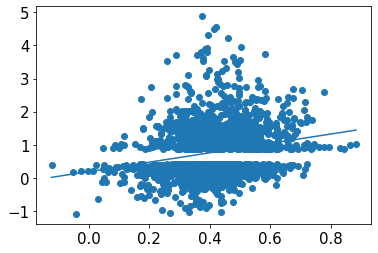

In [258]:
dataset_col = "our_full"
plt.scatter(crossposting_df[dataset_col], crossposting_df['pmi'])
plt.plot(np.unique(crossposting_df[dataset_col]), np.poly1d(np.polyfit(crossposting_df[dataset_col], crossposting_df['pmi'], 1))(np.unique(crossposting_df[dataset_col])))

In [303]:
lr_fit = lr.fit(np.array(crossposting_df['our_full'].tolist()).reshape(-1, 1),  crossposting_df['label'])
lr_fit.predict_proba(np.array(crossposting_df['our_full'].tolist()).reshape(-1, 1))[:, 0]

array([0.50392326, 0.53925458, 0.56328329, 0.48683413, 0.5442338 ,
       0.53753667, 0.54122448, 0.52284343, 0.53274746, 0.52976073,
       0.51081642, 0.50464341, 0.50006524, 0.49599411, 0.52071937,
       0.51763933, 0.49363109, 0.48193214, 0.49145995, 0.55589329,
       0.52609795, 0.51854484, 0.54823076, 0.5139663 , 0.51840189,
       0.50535395, 0.47497611, 0.50809685, 0.47175483, 0.50574674,
       0.51753377, 0.52493948, 0.51173633, 0.50467205, 0.51158132,
       0.50575805, 0.51439479, 0.50065115, 0.50437909, 0.48289849,
       0.45990577, 0.49310637, 0.50247216, 0.49657524, 0.51081599,
       0.50621575, 0.4656401 , 0.50757776, 0.48869334, 0.37673544,
       0.46669556, 0.49015099, 0.51061832, 0.55046898, 0.52501652,
       0.47947266, 0.50900049, 0.53786749, 0.44889573, 0.50661462,
       0.48997075, 0.52543165, 0.46091959, 0.43291428, 0.52599987,
       0.53386726, 0.54529013, 0.49631951, 0.49797025, 0.50786115,
       0.47980295, 0.50741424, 0.47852179, 0.49820221, 0.49551

In [215]:
# lr = LogisticRegression(cv=5, random_state=42)
# lr_fit = lr.fit(np.array(train['pav_partial'].tolist()).reshape(-1, 6), train['label'])
# lr_fit.score(np.array(test['pav_partial'].tolist()).reshape(-1, 6), test['label'])

0.35

In [216]:
lr = LogisticRegression(cv=5, random_state=42)
lr_fit = lr.fit(np.array(train['our_full'].tolist()).reshape(-1, 1), train['label'])
lr_fit.score(np.array(test['our_full'].tolist()).reshape(-1, 1), test['label'])

0.8

In [217]:
lr = LogisticRegression(cv=5, random_state=42)
lr_fit = lr.fit(np.array(train['our_partial'].tolist()).reshape(-1, 6), train['label'])
lr_fit.score(np.array(test['our_partial'].tolist()).reshape(-1, 6), test['label'])

0.55